<a href="https://colab.research.google.com/github/Salma1-dev/gomycode_excersises/blob/main/Copy_of_To_Do_CP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

# New Section

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!gdown --id 1YSsad6RtNW8esM0lT2yUudk5U3pj1ZGO

Downloading...
From: https://drive.google.com/uc?id=1YSsad6RtNW8esM0lT2yUudk5U3pj1ZGO
To: /content/small_complaints.csv
100% 51.5M/51.5M [00:00<00:00, 63.0MB/s]


# Data 

In [29]:
data = pd.read_csv('small_complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

In [30]:
data = data[["Product","Consumer complaint narrative"]]

In [31]:
data.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
4,Debt collection,While checking my credit report I noticed thre...


In [32]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    20202
Debt collection                                                                  9230
Credit card or prepaid card                                                      4332
Mortgage                                                                         3475
Checking or savings account                                                      2538
Student loan                                                                     1540
Vehicle loan or lease                                                            1083
Money transfer, virtual currency, or money service                               1019
Payday loan, title loan, or personal loan                                         880
Consumer Loan                                                                       6
Payday loan                                                                         5
Credit card                                           

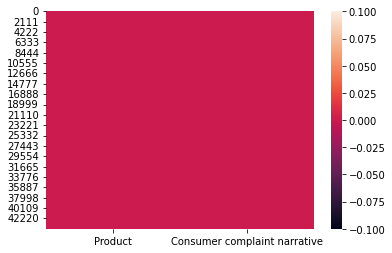

In [33]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [34]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [35]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"

data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account or service', 'Product'] = 'Other financial service'

# We will not consider other financial service
# Code Here
data = data[data.Product != 'Other financial service']


In [36]:
data = data.reset_index(drop=True)

In [37]:
data

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
4,Debt collection,While checking my credit report I noticed thre...
...,...,...
44307,Mortgage,"To whom it may concern, Four or five years ago..."
44308,"Credit reporting, credit repair services, or o...",FOR MONTHS I HAVE BEEN ASKING EQUIFAX TO REMOV...
44309,Credit card or prepaid card,My accounts at Capital One were closed. I trie...
44310,"Credit reporting, credit repair services, or o...",I received my Credit Report from all 3 credit ...


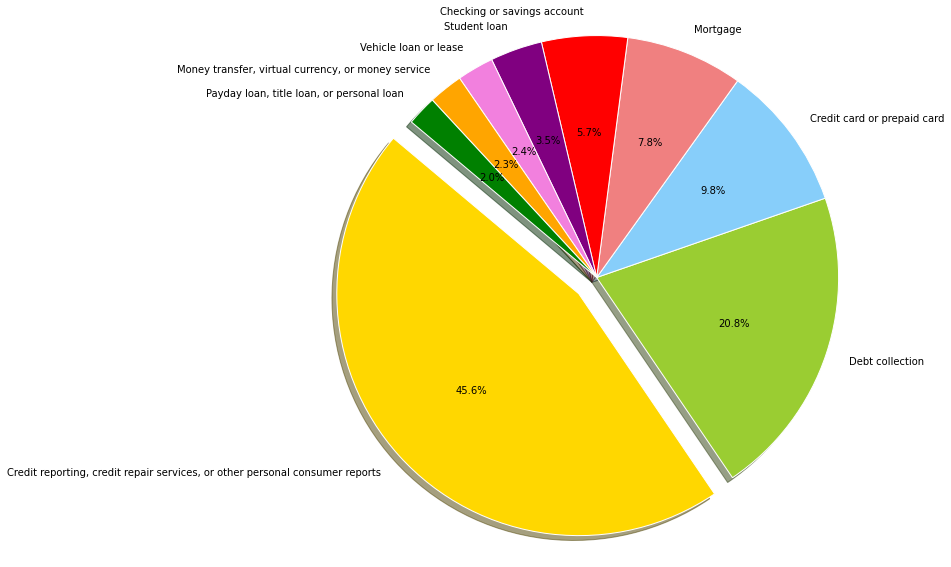

In [38]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [39]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [40]:
complaint_product(10, data)

ALL THREE CREDIT BUREAUS ARE STILL PUTTING FRAUD ALERTS ON MY CREDIT REPORT WITHOUT MY PERMISSION. 

IT SEEMS XXXX IS THE ONE INITIATING THIS AND THEN TELLING THE OTHER BUREAUS TO FOLLOW THEIR LEAD.

THIS IS ILLEGAL, I HAVE NOT REQUESTED THAT ANY FRAUD ALERT BE PUT ON MY CREDIT FILE.

I CHALLENGE THEM ON THE FCRA SECTION 609 TO REMOVE NEGATIVE REMARKS, STATEMENTS AND CREDIT INQUIRIES THAT WERE SUPPOSED TO BE SOFT PULLS AND NOT HARD PULLS AND THESE BUREAUS TRY TO SLIDE PAST THE LAW AND PUT THESE BOGUS FRAUD ALERTS ON MY FILES TO JUSTIFY THEIR ILLEGAL ACTIVITIES. 

NO NEGATIVE REMARKS SHOULD BE ON ANY OF MY OPEN OR CLOSED ACCOUNTS. NO REMARKS STATING THAT CONSUMER DISAGREES, REINVESTIGATION IN PROGRESS, NOTHING THAT SAYS CONSUMER DISPUTES AS I AM AT THIS TIME NOT DISPUTING ANYTHING AND THESE REMARKS AND THESE FRAUD ALERTS ARE BEING PLACED ON MY FILES WITHOUT MY PERMISSION AND ARE AGAINST THE LAW.
------------------------------
Product :  Credit reporting, credit repair services, or other

In [41]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [42]:
# Code Here
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(clean_text) # apply clean_text function 

In [43]:
data

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc trying collect debt min...
1,"Credit reporting, credit repair services, or o...",would like request suppression following items...
2,Debt collection,past weeks receiving ecessive amounts telephon...
3,"Money transfer, virtual currency, or money ser...",sold access event digitally screenshots detail...
4,Debt collection,checking credit report noticed three collectio...
...,...,...
44307,Mortgage,may concern four five years ago refinanced hom...
44308,"Credit reporting, credit repair services, or o...",months asking equifa remove fraudulent account...
44309,Credit card or prepaid card,accounts capital one closed tried get reopened...
44310,"Credit reporting, credit repair services, or o...",received credit report credit bureaus inquiry ...


In [45]:
# After cleaning
complaint_product(10, data)

three credit bureaus still putting fraud alerts credit report without permission seems one initiating telling bureaus follow leadthis illegal requested fraud alert put credit filei challenge fcra section remove negative remarks statements credit inquiries supposed soft pulls hard pulls bureaus try slide past law put bogus fraud alerts files justify illegal activities negative remarks open closed accounts remarks stating consumer disagrees reinvestigation progress nothing says consumer disputes time disputing anything remarks fraud alerts placed files without permission law
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


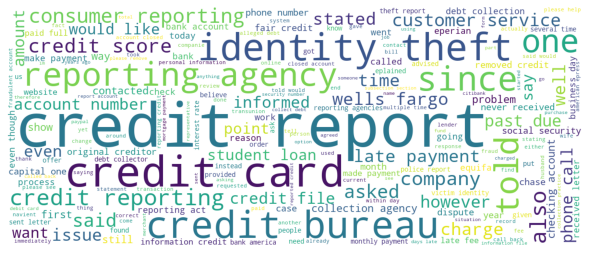

In [46]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [47]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

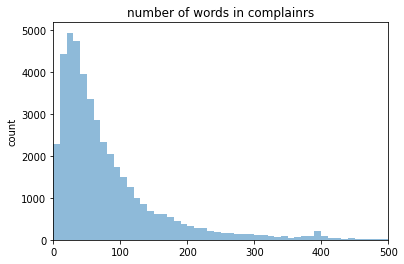

In [48]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

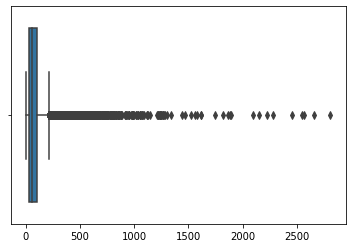

In [49]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [50]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 40377 unique tokens.


In [51]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (44312, 250)


In [52]:
X[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [53]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (44312, 9)


In [55]:
# Code Here
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35449, 250) (35449, 9)
(8863, 250) (8863, 9)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [63]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=250))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [64]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
499/499 [==============================] - 381s 757ms/step - loss: 1.1232 - accuracy: 0.6276 - val_loss: 0.9239 - val_accuracy: 0.6968
Epoch 2/5
499/499 [==============================] - 375s 752ms/step - loss: 0.7720 - accuracy: 0.7515 - val_loss: 0.8416 - val_accuracy: 0.7230
Epoch 3/5
499/499 [==============================] - 375s 752ms/step - loss: 0.6301 - accuracy: 0.7967 - val_loss: 0.7062 - val_accuracy: 0.7732
Epoch 4/5
499/499 [==============================] - 375s 751ms/step - loss: 0.5660 - accuracy: 0.8152 - val_loss: 0.6865 - val_accuracy: 0.7873
Epoch 5/5
499/499 [==============================] - 375s 751ms/step - loss: 0.4923 - accuracy: 0.8435 - val_loss: 0.7233 - val_accuracy: 0.7805


In [67]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_train,Y_train)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

1108/1108 [==============================] - 76s 68ms/step - loss: 0.4775 - accuracy: 0.8604
Test set
  Loss: 0.48
  Accuracy: 0.86


Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [68]:
Y_pred = model.predict(X_test)

In [69]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [73]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

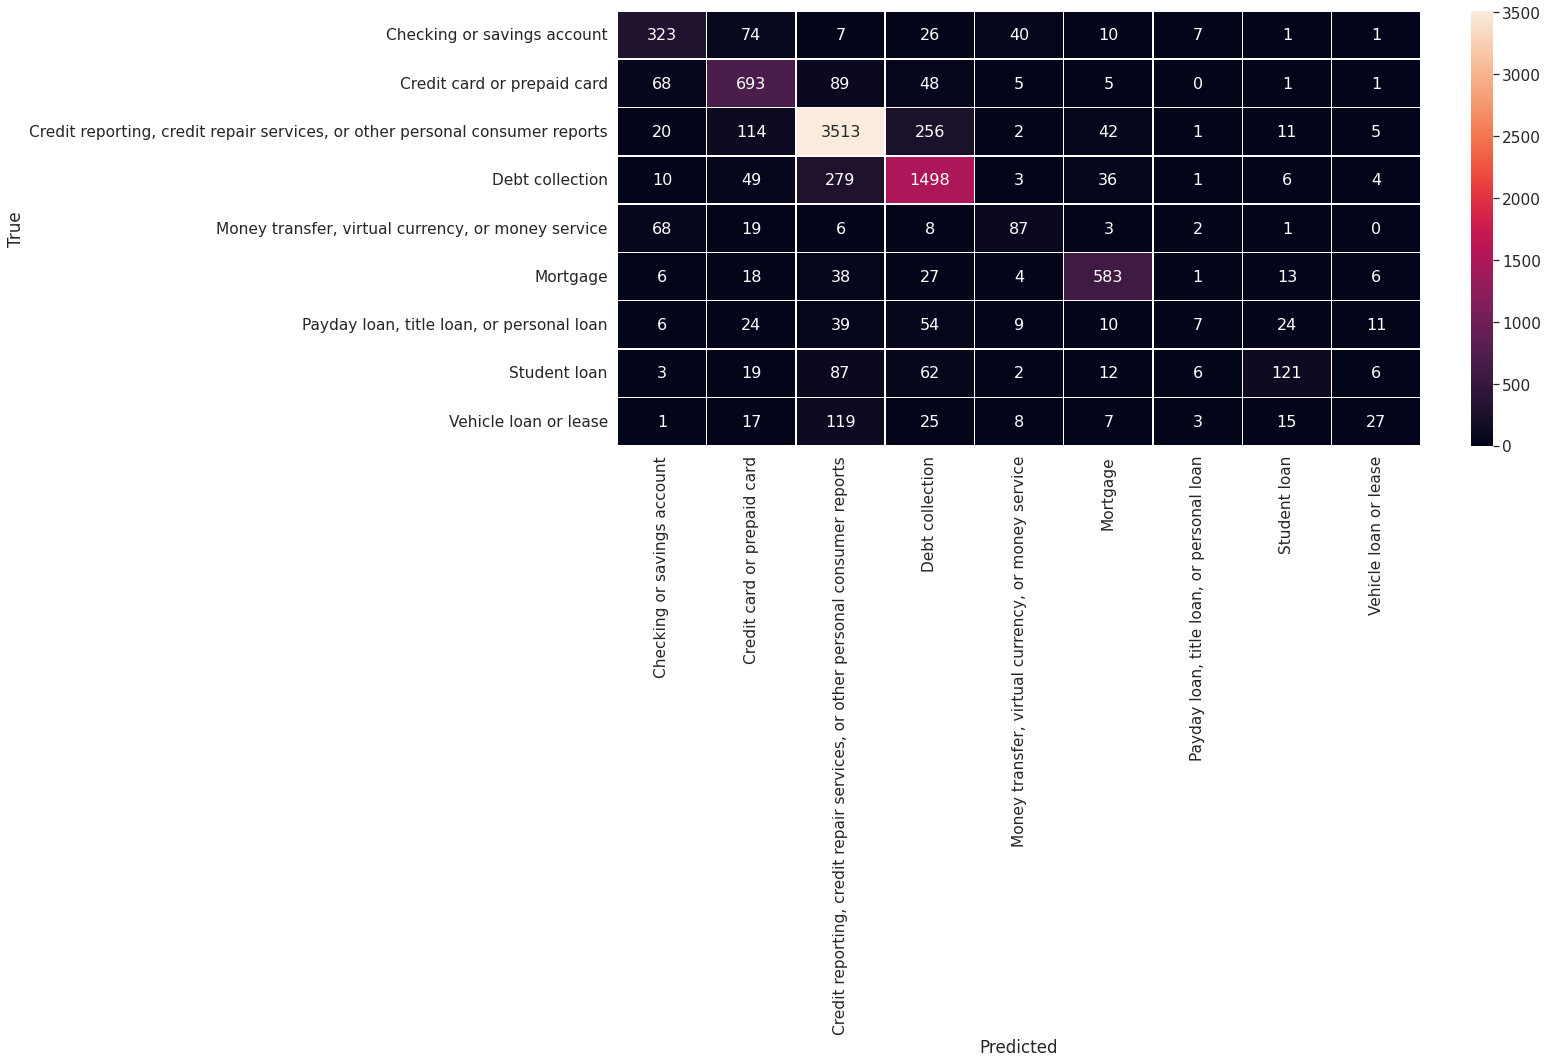

In [74]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()